In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import utilities as utils
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings

In [2]:
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

test = pd.read_pickle(pickle_path / "test.pkl")
train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")
houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)


Number of Outliers: 37
Percent Removed: 2.33%



In [23]:
# Verify that we don't have any negative readings
# This indicates a fundamental error in the data measurement
test = np.where(train.stack() < 0, True, False)
for value in test: 
    if value == True: 
        print("Error. Training data contains negative values.")
        break
else:
    print("No negative power readings in the dataset.")

No negative power readings in the dataset.


In [3]:
# Ratio of houses with and without EVs
ct_w = len(houses_wEV)
ct_wo = len(houses_woEV)
print("{:.2f}% of the training data houses own EVs".format(100*ct_w/(ct_w + ct_wo)))

# Separate into houses with and without EVs
train_w = train.drop(houses_woEV)
train_wo = train.drop(houses_wEV)
labels_w = labels.drop(houses_woEV)
# labels_wo is zero matrix

30.50% of the training data houses own EVs


In [4]:
# Determine stats for both classifications
stats = pd.DataFrame(index=train.index)
stats['tot_pwr'] = train.sum(axis=1)
stats['avg_pwr'] = train.mean(axis=1)
stats['median_pwr'] = train.median(axis=1)
stats['min_pwr'] = train.min(axis=1)
stats['max_pwr'] = train.max(axis=1)
stats['tot_chrgs'] = labels.sum(axis=1)
stats['bool_EV'] = np.where(stats['tot_chrgs'] > 0, True, False)

stats.drop(outliers.index, errors='ignore', inplace=True)

In [5]:
# Split stats by class
stats_wEV = stats.drop(houses_woEV, errors='ignore').drop(outliers.index, errors='ignore')
stats_woEV = stats.drop(houses_wEV, errors='ignore').drop(outliers.index, errors='ignore')


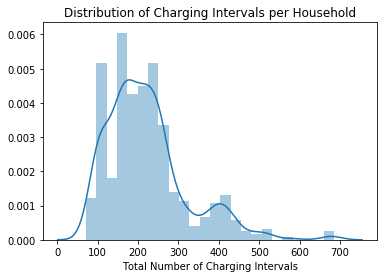

In [6]:
# Distribution of the number of charges
plot = sns.distplot(stats_wEV['tot_chrgs'].values);
plt.title('Distribution of Charging Intervals per Household');
plt.xlabel('Total Number of Charging Intervals');
plot.get_figure().savefig(fig_path / "labels_dist_tot_chrgs.png")

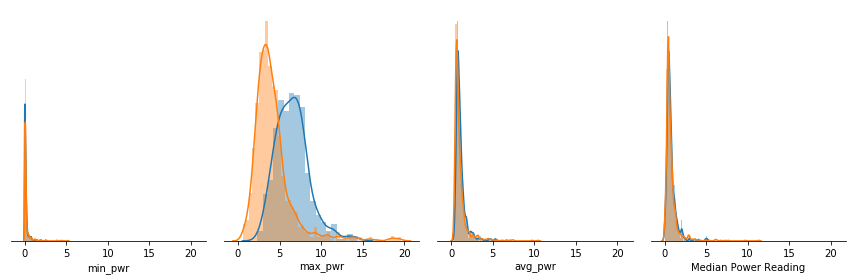

In [7]:
# Plot distribution of summary stats
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharex=True)
sns.despine(left=True)

# Min Power Reading
sns.distplot(stats_wEV['min_pwr'], ax=axes[0])
sns.distplot(stats_woEV['min_pwr'], ax=axes[0])
plt.xlabel('Minimum Power Reading');

# Max Power Reading
sns.distplot(stats_wEV['max_pwr'], ax=axes[1])
sns.distplot(stats_woEV['max_pwr'], ax=axes[1])
plt.xlabel('Maximum Power Reading');

# Mean Power Reading
sns.distplot(stats_wEV['avg_pwr'], ax=axes[2])
sns.distplot(stats_woEV['avg_pwr'], ax=axes[2])
plt.xlabel('Average Power Reading');

# Median Power Reading
sns.distplot(stats_wEV['median_pwr'], ax=axes[3])
sns.distplot(stats_woEV['median_pwr'], ax=axes[3])
plt.xlabel('Median Power Reading');


plt.setp(axes, yticks=[])
plt.tight_layout()
f.savefig(fig_path / "stats_subplots.png")

# Feature Analysis and Engineering
After reviewing the basic statistical profile of the data, it's clear that these features alone won't distinguish the EV and non-EV hosueholds. Therefore, more feature engineering is required. 

In [9]:
# Features from b_prep_training_data
features = pd.read_pickle(pickle_path / "features.pkl")

features_wEV = features.drop(houses_woEV, errors='ignore')
features_woEV = features.drop(houses_wEV, errors='ignore')

features_reduced = features_wEV.sample(100000)

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


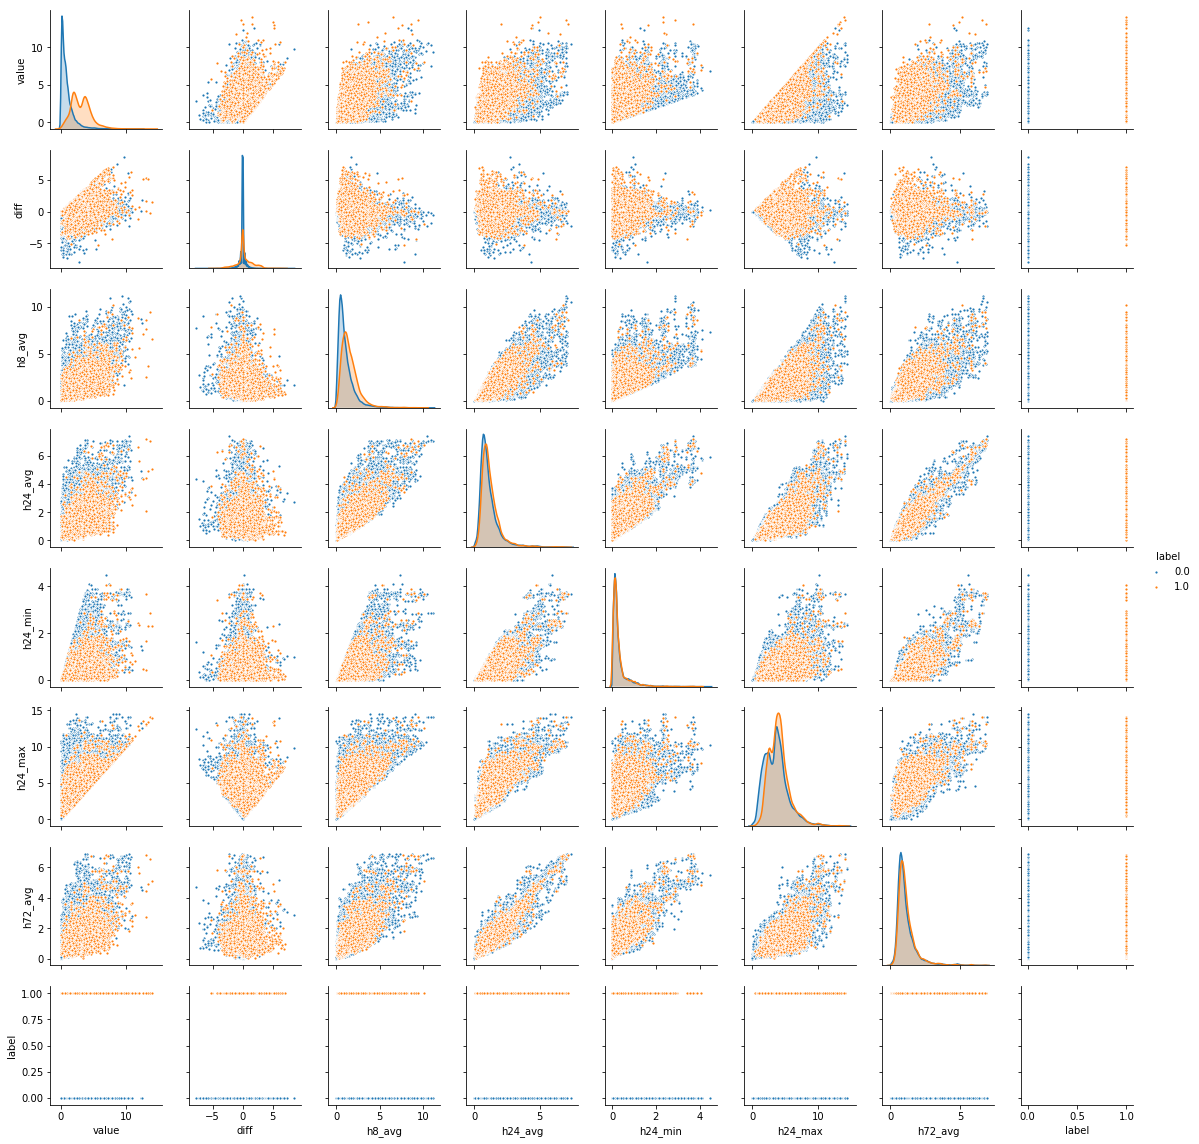

In [10]:
fig = sns.pairplot(features_reduced, height=2, hue='label', markers='.');
fig.savefig(fig_path / "feature_pair_plots_all.png")

In [24]:
# Consider other permutations of the features. 
# Logistic regress can find linear combinations, therefore, consider non-linear
features['diff_2'] = features['diff']**2
features['diff_3'] = features['diff']**3
features['diff_5'] = features['diff']**5

features_reduced = features.sample(100000)

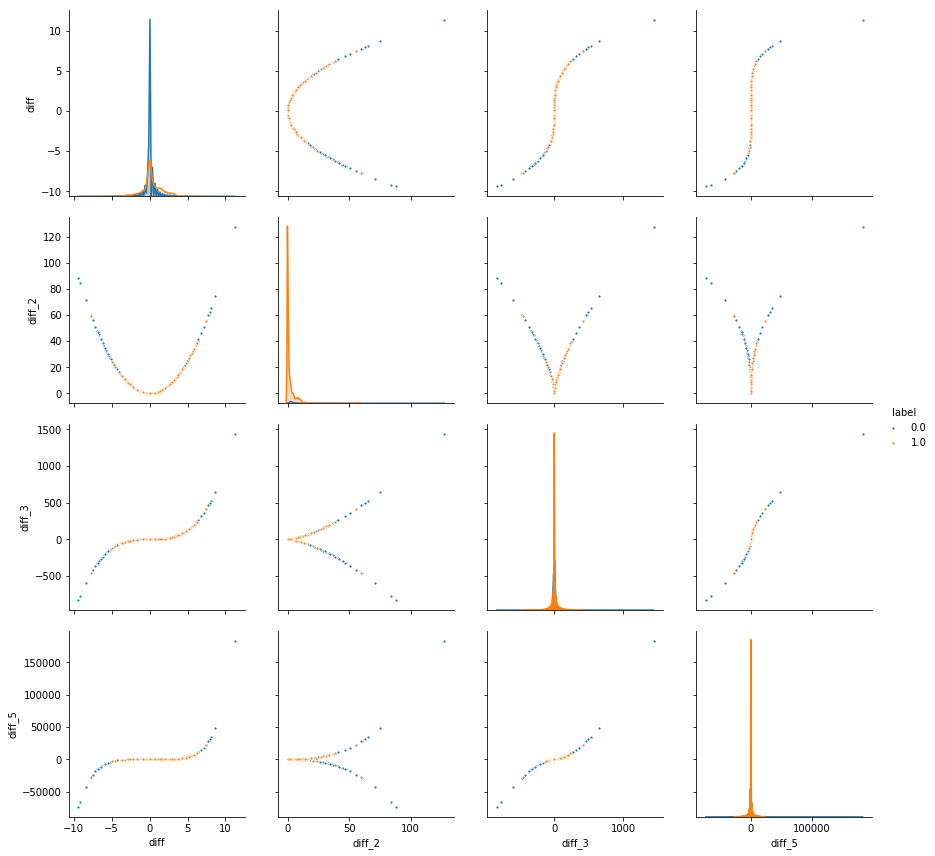

In [25]:
# ['value', 'diff', 'h8_avg', 'h24_avg', 'h24_min', 'h24_max', 'h72_avg','label', 'diff_2', 'diff_3']
fig = sns.pairplot(features_reduced, 
                   height=3, hue='label', markers='.',
                   vars=['diff', 'diff_2', 'diff_3', 'diff_5']);
fig.savefig(fig_path / "feature_pairplt_diffs1.png")

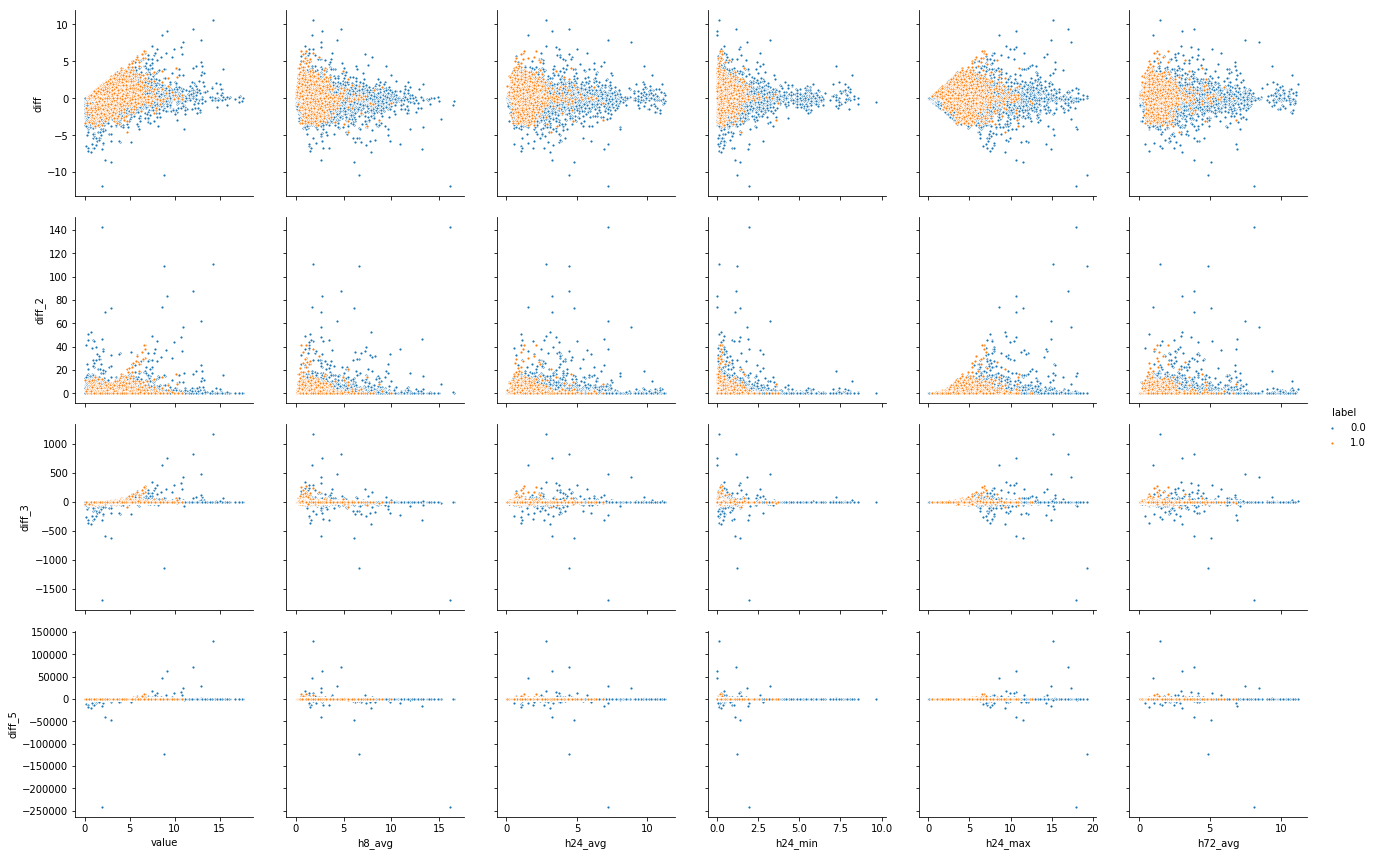

In [13]:
# ['value', 'diff', 'h8_avg', 'h24_avg', 'h24_min', 'h24_max', 'h72_avg','label', 'diff_2', 'diff_3']
fig = sns.pairplot(features_reduced, 
                   height=3, hue='label', markers='.',
                   y_vars=['diff', 'diff_2', 'diff_3', 'diff_5'],
                   x_vars=['value', 'h8_avg', 'h24_avg', 'h24_min', 'h24_max', 'h72_avg']);
fig.savefig(fig_path / "feature_pairplt_diffs2.png")